In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Challenge

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Challenge


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from data_preparation import load_data, delete_outliers
import numpy as np
from visualization import plot_history
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import random
import cv2
import os
from sklearn.utils.class_weight import compute_class_weight

In [3]:
seed = 25

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Utils Functions

In [4]:
def load_data(folder="public_data.npz", resolution=96, head_only=False):
    images = []

    loaded = np.load(folder, allow_pickle=True)

    # Iterate through files in the specified folder
    for i, img in enumerate(loaded['data']):
        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        #img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        #img = tfkl.Resizing(224, 224)(img)
        img = tfkl.Resizing(resolution, resolution)(img)

        if img is not None:
            images.append(img)

        if (head_only and i == 9):
           break

    labels = loaded['labels']
    loaded.close()

    if (head_only):
       labels = labels[:10]

    y = LabelEncoder().fit_transform(labels)
    #y = tfk.utils.to_categorical(y, 2)

    return np.array(images), y

def display_random_images(X, y, num_img=10):
  # Create subplots for displaying items
  fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
  for i in range(num_img):
      image = random.randint(0, X.shape[0] - 1)

      ax = axes[i%2, i%num_img//2]
      ax.imshow(np.clip(X[image], 0, 255))  # Display clipped item images
      ax.text(0.5, -0.1, str(image) + ' ' + str(y[image]), size=12, ha="center", transform=ax.transAxes)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

def delete_outliers(X, y):
  shrek = 137
  trololo = 5143

  new_X = []
  new_y = []

  num_outliers = 0

  for i, sample in enumerate(X):
    if (not (np.array_equal(sample, X[shrek]) or np.array_equal(sample, X[trololo]))):
      new_X.append(sample)
      new_y.append(y[i])
    else:
      num_outliers += 1

  return np.array(new_X), np.array(new_y), num_outliers


def plot_history(history, name, patience=20):
    plt.figure(figsize=(11,5))
    plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Val Accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_precision'], label='Val Precision', alpha=.8, color='red')
    plt.plot(history['val_recall'], label='Val Recall', alpha=.8, color='blue')
    plt.legend(loc='upper left')
    plt.title(name + ' Accuracy')
    plt.grid(alpha=.3)

    plt.text(0.5, -0.1, 'Train accuracy: ' + str(round(history['accuracy'][-patience-1], 4)) + ', Val accuracy: ' + str(round(np.max(history['val_accuracy']), 4)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.figure(figsize=(11,5))
    plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Val', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.show()

#### Data Loading end preparation

In [5]:
X, y = load_data('public_data.npz')
X, y, num_outliers = delete_outliers(X, y)

In [6]:
# Split data into train_val and test sets
X_train_0, X_val, y_train_0, y_val = train_test_split(X, y, test_size=500, stratify=y, random_state=seed)

# Further split train_val into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=500, stratify=np.argmax(y_train_val,axis=1))

print(X_train_0.shape, y_train_0.shape)
print(X_val.shape, y_val.shape)

(4504, 96, 96, 3) (4504,)
(500, 96, 96, 3) (500,)


In [7]:
def augment_dataset(X, y):
  augment1 = tf.keras.Sequential([
      tfkl.RandomFlip(),
      tfkl.RandomTranslation(height_factor = (-0.2,0.2), width_factor = (-0.2,0.2), fill_mode = 'reflect'),
      tfkl.RandomZoom(0.3, fill_mode = 'reflect'),
      tfkl.RandomBrightness(0.1, value_range=(0,1)),
  ])

  augment2 = tf.keras.Sequential([
      tfkl.RandomFlip(),
      tfkl.RandomZoom(0.4, fill_mode = 'reflect'),
      tfkl.RandomBrightness(0.1, value_range=(0,1)),
      tfkl.RandomRotation((-1,1), fill_mode = 'reflect'),
  ])

  new_X_train_1 = augment2(X[y == 1])
  augmented_X_train_2 = augment2(X)
  augmented_X_train_1 = augment1(augmented_X_train_2)

  X = np.append(X, augmented_X_train_2, axis = 0)
  X = np.append(X, augmented_X_train_1, axis = 0)
  X = np.append(X, new_X_train_1, axis = 0)

  y_tmp = np.append(y, y)
  y = np.append(y_tmp, y)
  for k in range(new_X_train_1.shape[0]):
      y = np.append(y, 1)
  return X, y

In [8]:
X_train, y_train = augment_dataset(X_train_0, y_train_0)

#Shuffle the dataset
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# Define key model parameters
input_shape = X_train.shape[1:]
batch_size = 16
epochs = 400

print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

(10721, 96, 96, 3)
(10721,)
(array([0., 1.]), array([5582, 5139]))


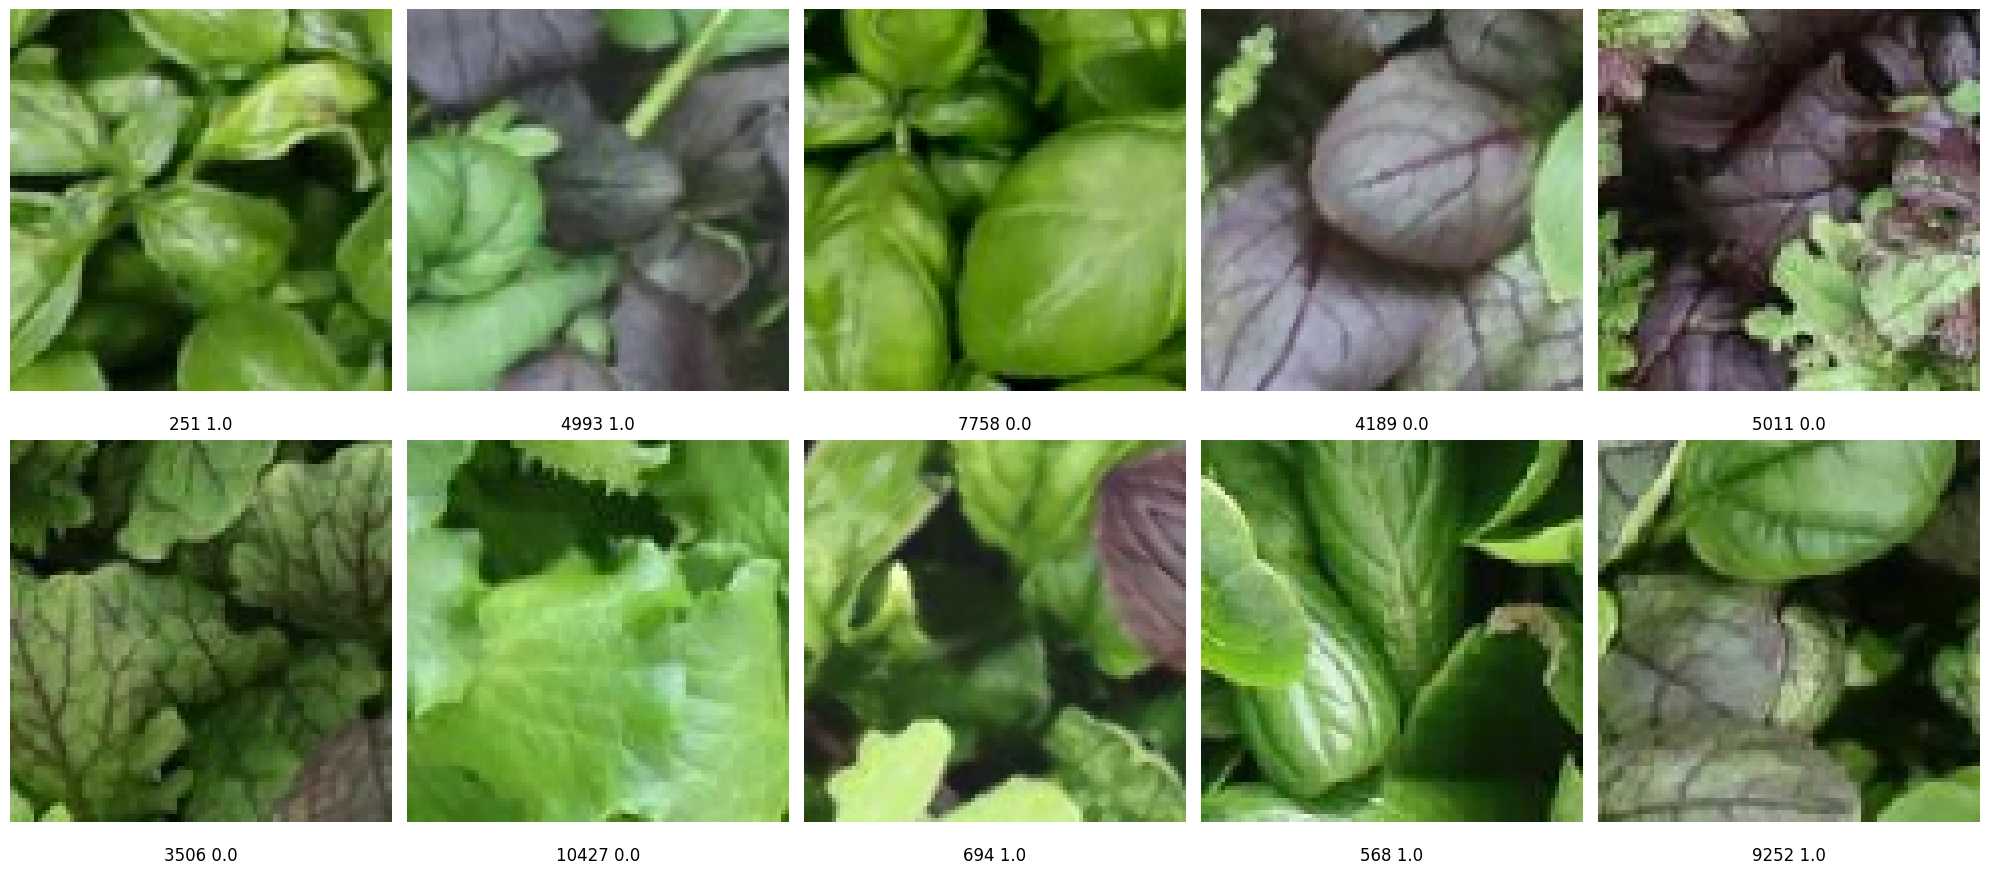

In [10]:
display_random_images(X_train, y_train)

#### Model building and validation

In [13]:
def get_block(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dense(neurons)(x)
    if (batch_normalization):
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(dropout)(x)
    return x

def build_model(input_shape, learning_rate=1e-4, neurons=[], base_dropout=0, dropouts=[], batch_normalization=False, name="model", weight_decay=3e-5):
  mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
  )

  mobile.trainable = False
  inputs = tfk.Input(shape=input_shape)
  # Connect MobileNetV2 to the input
  x = mobile(inputs)
  x = tfkl.Dropout(base_dropout)(x)

  for i, n in enumerate(neurons):
      x = get_block(x, n, batch_normalization=batch_normalization, dropout=dropouts[i])

  # Add a Dense layer with 2 units and softmax activation as the classifier
  outputs = tfkl.Dense(1, activation='sigmoid')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay), metrics=['accuracy', tfk.metrics.Precision(name="precision"), tfk.metrics.Recall(name="recall")])

  # Display model summary
  model.summary()

  return model

In [15]:
models = [
    build_model(input_shape, learning_rate=1e-4, neurons=[64, 16], dropouts=[1/7, 1/7], base_dropout=1/5, batch_normalization=True, weight_decay=3e-5),
]

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weight = {
    0: weights[0],
    1: weights[1]
}

histories = []

patience = 30

for i, model in enumerate(models):
  histories.append(model.fit(
      x = tfk.applications.mobilenet.preprocess_input(X_train * 255), # We need to apply the preprocessing thought for the MobileNetV2 network
      y = y_train,
      #class_weight = class_weight,
      batch_size = 16,
      epochs = 400,
      validation_data = (tfk.applications.mobilenet.preprocess_input(X_val * 255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 15, min_lr = 5e-6)
      ]
  ).history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 64)                0     

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

for history in histories:
  predictions = models[i].predict(tfk.applications.mobilenet.preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  print('AUC: ' + str(roc_auc))
  print('Best Epoch: ' + str(len(history['val_accuracy']) - patience))
  plot_history(history, patience=30, name="")

In [ ]:
model = models[0]
model.save("TransferLearningModel")
del model

In [ ]:
def fine_tune(layers, learning_rate):
  model = tf.keras.models.load_model("TransferLearningModel")

  layers = len(model.get_layer('mobilenetv2_1.00_96').layers) - layers

  model.get_layer('mobilenetv2_1.00_96').trainable = True

  # Freeze first N layers, e.g., until the 133rd one
  for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:layers]):
    layer.trainable=False

  for layer in model.get_layer('mobilenetv2_1.00_96').layers[layers:]:
    print(layer)

  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

  return model

In [ ]:
histories = []


models = [
    fine_tune(12, 1e-5),
]

patience = 20

batch_size = 16

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = {
    0: weights[0],
    1: weights[1]
}

steps_per_epoch = len(X_train) // batch_size

for i, model in enumerate(models):
  histories.append(
      model.fit(
        x = tfk.applications.mobilenet.preprocess_input(X_train * 255),
        y = y_train,
        class_weight=class_weights,
        batch_size = batch_size,
        epochs = 200,
        validation_data = (tfk.applications.mobilenet.preprocess_input(X_val * 255), y_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True, start_from_epoch=5),
          #tfk.callbacks.ModelCheckpoint('modelB' + str(i) + '_weights_epoch_{epoch:02d}.h5', save_weights_only=True, save_freq=5 * steps_per_epoch),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-7, mode='max')
        ]
  ).history)

In [ ]:
for i, history in enumerate(histories):
  predictions = models[i].predict(tfk.applications.mobilenet.preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  plot_history(history, models[i].name, patience=patience)

Test set accuracy 0.8120


In [ ]:
models[0].save("Submission")